In [3]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [4]:
env = BlackjackEnv()

In [38]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        policy = np.ones(nA, dtype=np.float32) * epsilon / nA
        a_star_ind = np.argmax(Q[observation])
        policy[a_star_ind] = 1 - epsilon + epsilon / nA
        return policy
    
    return policy_fn

In [71]:

def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    observation = env.reset()
    
    for ep in range(num_episodes):
        observation = env.reset()
        # Generate episode observations
        done = False
        episode_flow = []
        while not done:
            probs = policy(observation)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            obs_next, reward, done, _ = env.step(action)
            episode_flow.append([observation, action, reward])
            observation = obs_next
        
        g = 0
        for t in range(len(episode_flow)-1, -1, -1):
            visited_states = {(ep[0], ep[1]) for ep in episode_flow[:t-1]} if t > 0 else {}
            state, action, reward = episode_flow[t]
            g = g * discount_factor**t + reward
            
            state_action = (state, action)
            
            if state_action not in visited_states:
                returns_sum[state_action] += g
                returns_count[state_action] += 1
                
                Q[state][action] = returns_sum[state_action] / returns_count[state_action]
                
        if ep % 1000 == 0:
            print("\rEpisode {}/{}.".format(ep, num_episodes), end="")
    return Q, policy

In [74]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=300000, epsilon=0.1)

Episode 299000/300000.

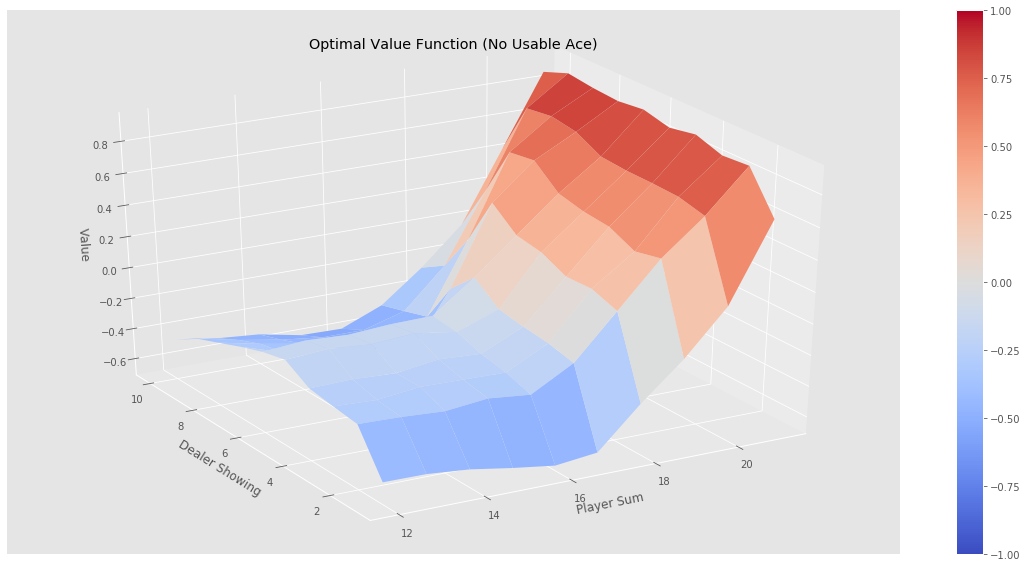

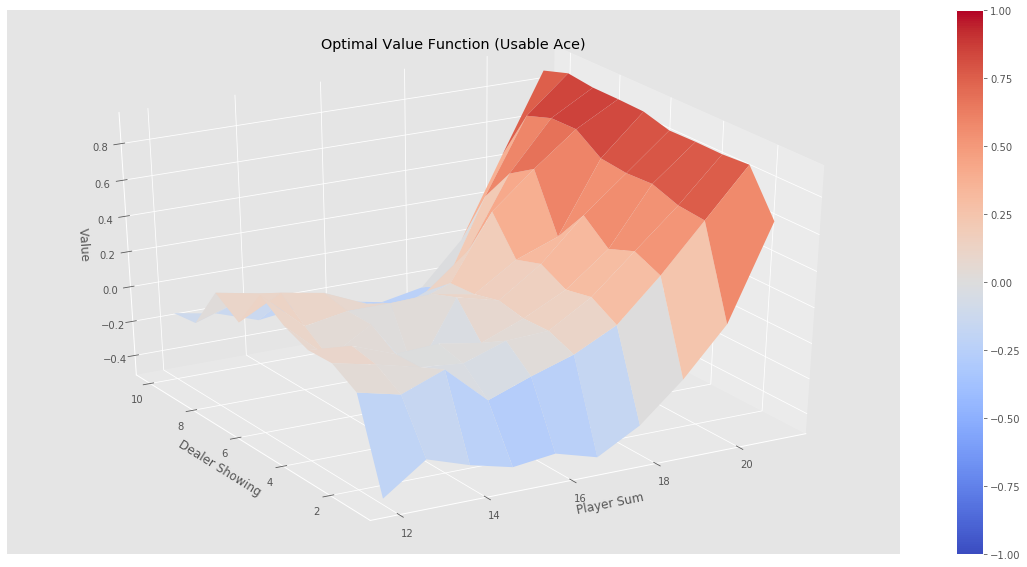

In [75]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")